<a href="https://colab.research.google.com/github/CFIN-analysis/analysis_workshop_26May/blob/main/Notebooks/1_GLHMM_intro_module_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# GLHMM Workshop - Introductory module

This notebook is meant as a guide and example of instantiating and training a TDE-HMM and visualising its output. The notebook is based on one of the [available tutorials](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/HMM-TDE_vs_HMM-MAR_example.ipynb) in the GLHMM toolbox.

The notebook sketches a hypothetical neuroscience project, with the aim to find common networks across participants in resting state whole-brain MEG data.

This notebook is scheduled as follows:

0. [PREPARATION](#preparation)
1. [Download data](#download)
2. [Basic data preprocessing](#preprocess)
3. [Instantiate TDE-HMM](#HMM_instantiate)
4. [Train HMM](#HMM_train)  -  here you will have the option to load a trained HMM, and go directly to the plotting section.
5. [Basic sanity checks and summary metrics](#sanity_checks)
6. [States spectral analysis](#spectral)

Authors: Laura Masaracchia, <laurama@cfin.au.dk>

## 0. PREPARATION <a id="preparation"></a>

If you dont have the **GLHMM-package** installed, or if you have not yet installed it using **Google Colab**, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```



In [47]:
!pip install -q git+https://github.com/vidaurre/glhmm

#### Import necessary packages

In order to be able to run this notebook, you will also need some other packages. Please install them via pip install (follow syntax in previous cell) if the next cell does not run successfully.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from glhmm import glhmm, preproc, utils, graphics, spectral, io, statistics, auxiliary
import pickle
import pip

## 1. Download data <a id="download"></a>

The next two cells will fetch the data from the OSF website and download them into a new folder called "example_data" in the same folder as this notebook. If you prefer, you can create the folder and download the files from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666) and skip the next two cells.

In [49]:
def install(package):
    pip.main(['install', package])

try:
    import osfclient
except ImportError:
    print('osfclient is not installed, installing it now')
    install('osfclient')

In [ ]:
! osf -p 8qcyj fetch MEG_data/data_MEG_TDE.pkl ./example_data/data_MEG_TDE.pkl

### Load data in memory

We will now load the data in memory.

***This step is compulsory, whether you downloaded the data manually or running the previous two cells.***

In [51]:
# Loading the data

with open("./example_data/data_MEG_TDE.pkl", "rb") as f:
    data_meg_tde = pickle.load(f)

### Data information

The data we just loaded are whole-brain MEG resting state data. The data were collected from participants while resting in a dark room. Each participant completed two sessions, except for one participant with just one session.

Each session is stored as a 2D matrix with the shape of (No. of timepoints, No. of parcels):

- Timepoints: The total number of recorded time points in the session.
- Parcels: Here regions according to a prespecified parcellation.

These data are a subset of a dataset collected and used for the original [TDE-HMM paper](https://www.nature.com/articles/s41467-018-05316-z)

In [52]:
# Display data information
print("Number of sessions in data_meg: %d"%len(data_meg_tde))
print("Shape of each session: ")
for i in range(len(data_meg_tde)):
  print(data_meg_tde[i].shape)

Number of sessions in data_meg: 5
Shape of each session: 
(75685, 42)
(75762, 42)
(74934, 42)
(75512, 42)
(75643, 42)


### Prepare data in HMM-friendly format

We now need to make the data in the right format for the HMM, meaning concatenate all sessions and subjects along the time axis. We also need to create the indices that will indicate the start and end timepoint of each session:

- **Concatenated brain activity (Y)**:
The brain activity data (data_meg) contains recordings from multiple sessions. We concatenate all the sessions along the time dimension to form a single, continuous 2D matrix: [timepoints × sessions, features].

- **Create index matrix (idx_data)**:
To track the start and end timepoints for each session, we generate an index matrix, idx_data, using the function get_indices_from_list. It will have a shape of: [No. of sessions, 2]. Each row specifies the start and end timepoints for a session.



In [53]:
Y = np.concatenate(data_meg_tde,axis=0)

# Get the start and end indices for each session
idx_data = statistics.get_indices_from_list(data_meg_tde)

In [54]:
# show the length of the data
print('total length of data:')
print(len(Y))

# show indices
print('indices:')
print(idx_data)

total length of data:
377536
indices:
[[     0  75685]
 [ 75685 151447]
 [151447 226381]
 [226381 301893]
 [301893 377536]]


## 2. Basic data preprocessing <a id="preprocess"></a>

We always recommend to plot the data before doing any preprocessing, and understand what preprocessing steps might be appropriate. 

Check the [documentation](https://glhmm.readthedocs.io/en/latest/preproc.html) for the various preprocessing options in our toolbox.

***The data for this tutorial have already been preprocessed, so we will only standardise them.***



In [55]:
# Preprocess data - we will only use the default option, which is to standardise the data
Y, _, log = preproc.preprocess_data(Y, idx_data, standardise=True)

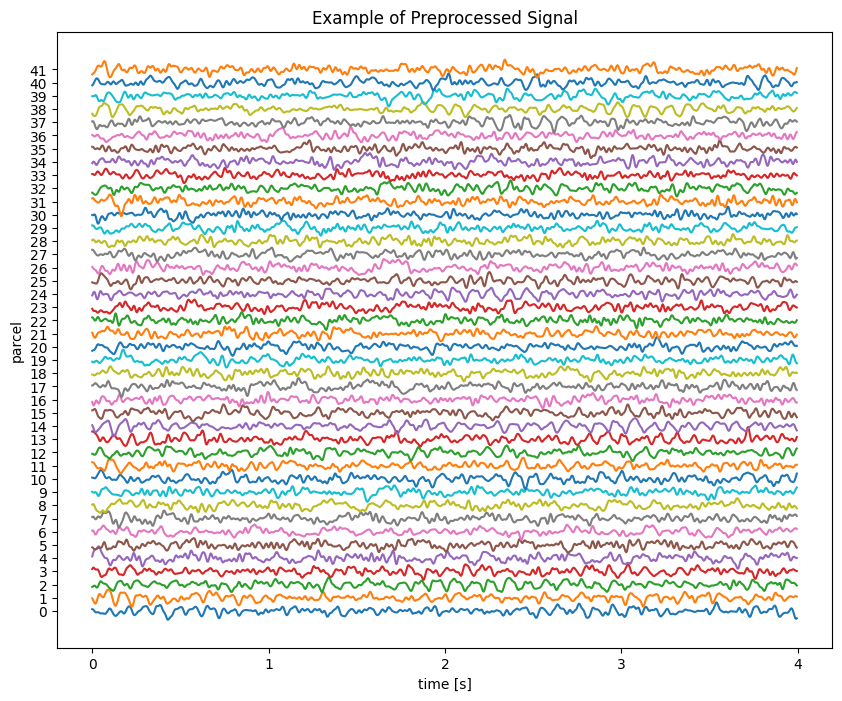

In [56]:
# visualize some data
# decide on a plotting range of the signal - this is arbitrary
plot_range = np.arange(100000,101000)

Fs = 250 # sampling frequency of the signal
n_channels = Y.shape[1]

# plot each parcel separately
fig = plt.figure(figsize=(10,8))
for i in range(n_channels):
    plt.plot(Y[plot_range,i]+i*5)

plt.xticks(np.arange(0,len(plot_range)+1,Fs),np.arange(int(len(plot_range)/Fs+1)))
plt.xlabel('time [s]')
plt.yticks(np.arange(0,n_channels*5,5),np.arange(n_channels))
plt.ylabel('parcel')
plt.title('Example of Preprocessed Signal')
plt.show()


## TDE-HMM

The TDE-HMM was introduced in [Vidaurre et al. (2018)](https://www.nature.com/articles/s41467-018-05316-z). This HMM models the autocovariance of the signal. Given a multichannel time series data *y*, the autocovariance is computed within a window of length 2L and resolution S around each time point *yt*. The window is specified by the user in the form of **lags** = (-L, -L+S, ...-S, 0, S, ..., L-S, L), indicating the time points around t to be included in the window.

## 3. Instantiate a TDE-HMM  <a id="HMM_instantiate"></a>
To run a TDE-HMM in with the GLHMM package, the data are first restructured (embedded) according to the **lags**, and then a Gaussian HMM is run on the embedded data. Here, the states are the covariance matrices that best describe the signal.  

1. **Embed data**: For the first step, we will use the `build_data_tde` option in the preprocessing module. This will create an embedded version of the data according to the **lags** we define. In this specific case, our window of lags will be of length 2L, where L=35, with resolution S=5. We will then use PCA on the embedded signal, using number of PC = number of parcels * 2, to follow the original [TDE-HMM paper](https://doi.org/10.1038/s41467-018-05316-z) preprocessing and HMM settings.

2. **Initialise HMM**: We then initialise the glhmm object, which we here call `TDE_hmm`. By specifying the parameters of the glhmm object, we define which type of model we want to fit and how states should be defined. We will model 10 states by setting the parameter `K=10`. We will also specify the covariance type as `covtype='full'` and no means modelling. So our states will be characterised only by functional connectivity (covariance).

In [57]:
# Specify time lags
S=5
L = 35
lags = np.arange(-L, L + 1, S)

# Build the MEG data in TDE format
Y_embedded, idx_tde, pca_model = preproc.build_data_tde(Y,idx_data,lags=lags,pca=n_channels*2)

# add information about the data embedding to the log, to keep track of all data transformations we have performed
log["pca"] = n_channels*2
log["pcamodel"] = pca_model
log["lags"] = lags

In [58]:
# instantiate model
K=10
TDE_hmm = glhmm.glhmm(model_beta='no', model_mean='state', K=K, covtype='full', preproclogY=log)

## 4. Train a TDE-HMM <a id="HMM_train"></a> (default: load a trained HMM)

We will now train the TDE-HMM. The training procedure will output the state time courses (Gamma), the joint probability of past and future states conditioned on the data (Xi) and the free energy computed at each iteration of the process (FE).

We will also get the Viterbi path (vpath, a categorical version of the Gamma).


***This step can take several minutes, up to an hour. For showing purposes, we will load a trained HMM instead.
If you want to train your own HMM, change the flag in the next cell to `train_HMM_flag=True` instead.***

In [59]:
# change this to True if you want to train your HMM
train_HMM_flag=False

In [ ]:
if train_HMM_flag:
    # train the HMM from scratch
    print('Training HMM-TDE')
    #options={'gpu_acceleration':2}
    options={}
    Gamma, Xi, FE = TDE_hmm.train(X=None, Y=Y_embedded, indices=idx_tde, options=options)
    vpath = TDE_hmm.decode(X=None, Y=Y_embedded, viterbi=True)
    
    # then save the HMM
    # save your trained hmm
    hmm_dict = {'hmm':TDE_hmm,'stc':Gamma,'xi':Xi,'fe':FE,'vpath':vpath}
    with open("./example_data/hmm_tde.pkl", "wb") as fp:
        pickle.dump(hmm_dict, fp, pickle.HIGHEST_PROTOCOL)
        
else:
    print('downloading pre-trained model')
    # download trained model
    ! osf -p 8qcyj fetch MEG_data/hmm_tde.pkl ./example_data/hmm_tde.pkl
    
# load into the notebook
with open('./example_data/hmm_tde.pkl', "rb") as f:
    hmm_dict = pickle.load(f)

TDE_hmm = hmm_dict['hmm']
Gamma = hmm_dict['stc']
vpath = hmm_dict['vpath']

### Padding Viterbi path and Gamma

Because of the delay-embeddings, the state time courses are now shorter than the original data. To be able to plot the signal with the Viterbi path, we need a padding operation to fill in the missing values of the HMM output. 

This is done with the function `padGamma()` below.

In [61]:
T = auxiliary.get_T(idx_data)
options_tde = {'embeddedlags':lags}
padded_vpath = auxiliary.padGamma(vpath, T, options_tde)

## 5. Basic sanity checks and summary metrics <a id="sanity_checks"></a>

We will now perform some basic sanity checks and plot summary metrics. These include:

*   Plot example of Viterbi path (vpath) with signal
*   Plot states fractional occupancy (FO)
*   Plot states switching rate (SR)
*   Plot states lifetimes (LT)
*   Plot states probabilities, mean (mu) and covariance (Sigma)

We will use the appropriate functions in the GLHMM `graphics` module to plot all these metrics. Check the [documentation](https://glhmm.readthedocs.io/en/latest/graphics.html) to see all our graphics options.



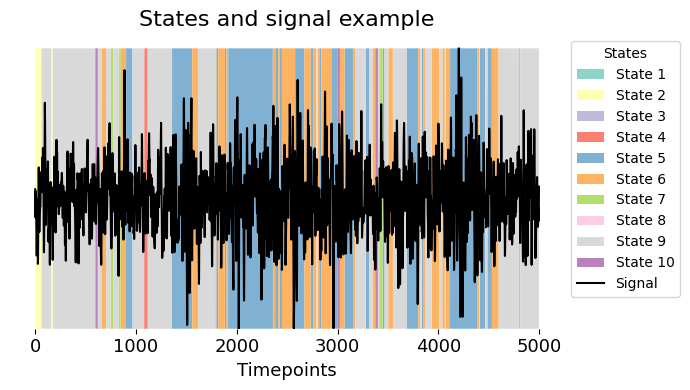

In [62]:
# plot state Viterbi path with signal
# define a plotting range
plotting_range = np.arange(15000,20000)

# use the appropriate function in the graphic package
graphics.plot_vpath(padded_vpath[plotting_range], signal=Y[plotting_range,1].copy(), title="States and signal example")


In [63]:
# inspect states - basic sanity checks
# Get summary metrics
FO = utils.get_FO(Gamma, indices=idx_tde)
SR = utils.get_switching_rate(Gamma, indices=idx_tde)
LTmean, LTmed, LTmax = utils.get_life_times(vpath, indices=idx_tde)

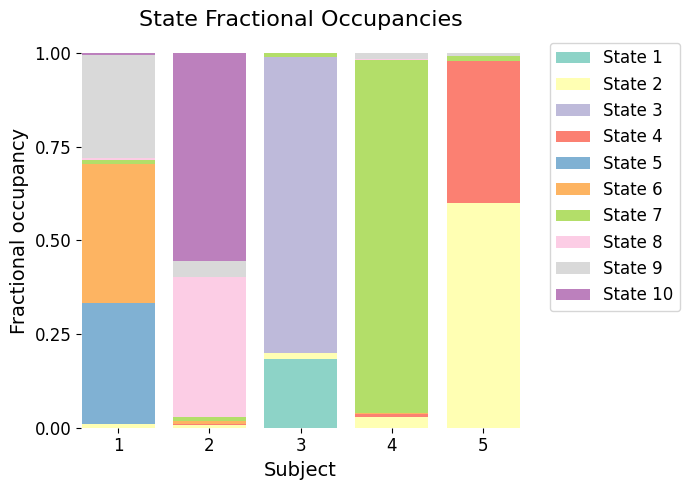

In [64]:
# plot some relevant statistics
graphics.plot_FO(FO,width=0.8, figsize=(7,5))

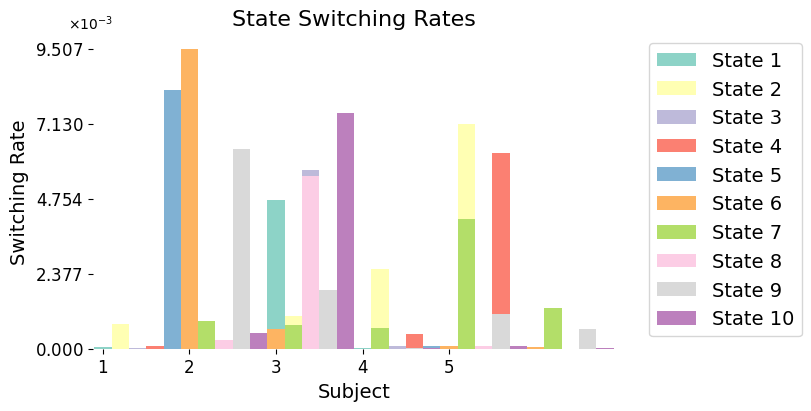

In [65]:
graphics.plot_switching_rates(SR,width=0.2)

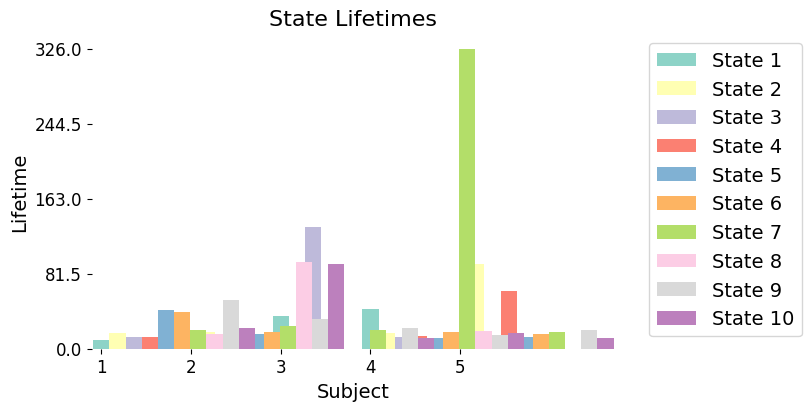

In [66]:
graphics.plot_state_lifetimes(LTmed)

In [69]:
# inspect states
# plot probabilities, mean (mu) and covariance (Sigma) of states 
# by default, the mean and covariance matrices will be backtransformed into the original high-dimensional space (n_channels * lags)
# alternatively, you can look at the state means and covariances in PCA space (see cell below):
#mu = TDE_hmm.get_means() 
#Sigma = TDE_hmm.get_covmats()
#graphics.plot_state_prob_and_covariance(TDE_hmm.Pi,TDE_hmm.P, mu, Sigma, figsize=(8,11))

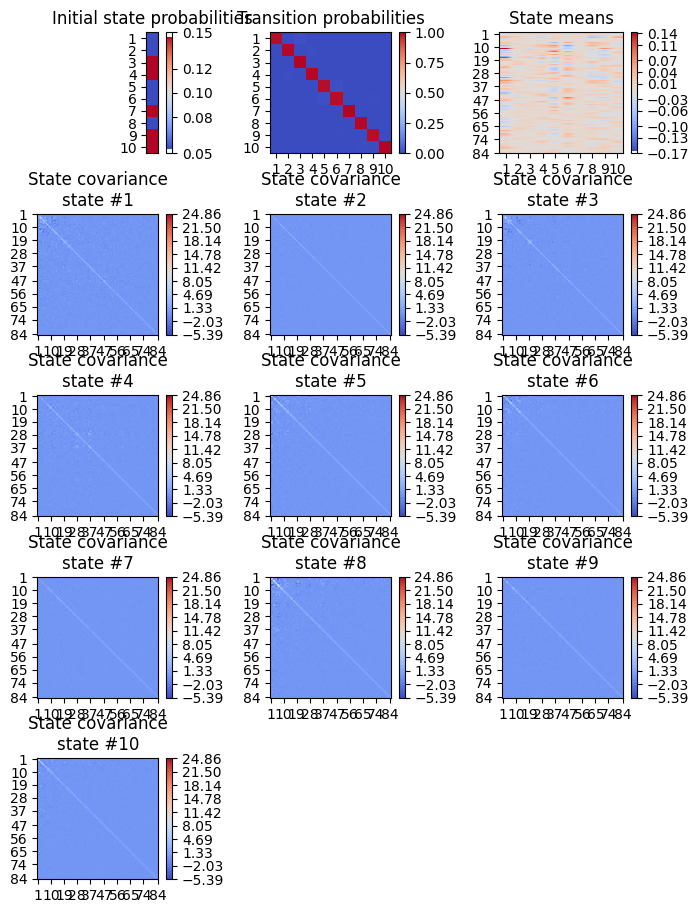

In [70]:
# here, you can look at the state means and covariances in PCA space (uncomment below):
mu = TDE_hmm.get_means(orig_space=False)
Sigma = TDE_hmm.get_covariance_matrices(orig_space=False)
graphics.plot_state_prob_and_covariance(TDE_hmm.Pi,TDE_hmm.P, mu, Sigma, figsize=(8,11))

## 6. States spectral analysis <a id="spectral"></a>

The states might pick up on some differences in the frequency of the signal. For example, one state might capture enhanced activity in the alhpa band during mind wondering, and another might focus on higher power in the beta band that reflected some kind of movement. So we wish to characterize the states spectrally.

To check the spectral properties of the states, we will use the `spectral` package in GLHMM. We will compute the states power spectra and coherence, and plot them.

This is done with the function `multitaper_spectral_analysis()` that uses the nonparametric multitaper approach.

The function needs to have specified the sampling frequency (Fs) of the data. In this case, `Fs=250`.

The function also needs the Gamma (i.e., the state probability time courses) to compute the power spectrum of each state. We can input the padded Gamma, or the original gamma, specifying in the options the `embeddedlags` used to train the HMM. In this last case, the function will pad the Gamma first.

You can also specify in the options for the spectral analysis `fpass`, the frequency range for the power spectrum estimation.

Check the [documentation](https://glhmm.readthedocs.io/en/latest/spectral.html) on how to specify more options for the multitaper spectral analysis.


In [71]:
# get states spectral properties
options = {'embeddedlags':lags, 'fpass':[0,100]}
spectral_measures = spectral.multitaper_spectral_analysis(Y, idx_data, Fs=250, Gamma=Gamma, options=options)

/Users/au673157/anaconda3/lib/python3.11/site-packages/glhmm/spectral.py:303: ComplexWarning: Casting complex values to real discards the imaginary part
  psdc[j,:,:,:,k] = psdc_sk.transpose(2,0,1)


The output of the `multitaper_spectral_analysis` function is a dictionary containing:
- 'f' : the frequency bins
- 'p' : the power spectrum of each state, per subject/session and per channel
- 'psdc' : the cross-channel power spectrum, per subject/session and per state
- 'coh' : the cross-channel coherence, per subject/session and per state

We will then use the functions in the `graphics` module to visualise the states spectra, with and without the option of hichlighting the standard frequency bands.

We will visualise them for one session and for two randomly selected channels.


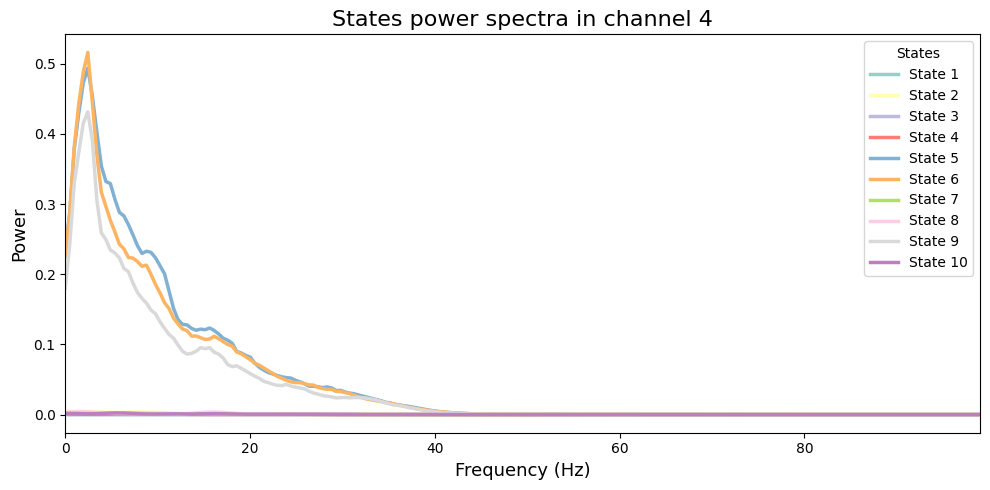

In [74]:
# plot the state power spectra for a specific session, and channel

selected_channel = 4
selected_session = 0

f = spectral_measures['f']
psd = spectral_measures['p']

graphics.plot_state_psd(psd[selected_session,:,selected_channel],
                        f,
                        highlight_freq=False,
                        title="States power spectra in channel %d"%selected_channel)

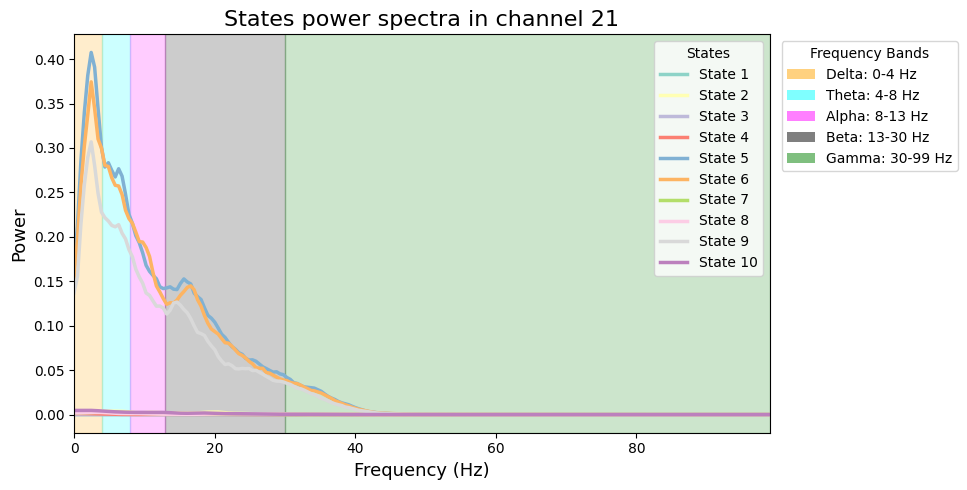

In [75]:
# plot the state power spectra for a specific session, and channel

selected_channel = 21
selected_session = 0

f = spectral_measures['f']
psd = spectral_measures['p']

graphics.plot_state_psd(psd[selected_session,:,selected_channel],
                        f,
                        highlight_freq=True,
                        title="States power spectra in channel %d"%selected_channel,)

We will then visualise the states cross-channels cohrence, for one session and between two randomly selected channels.


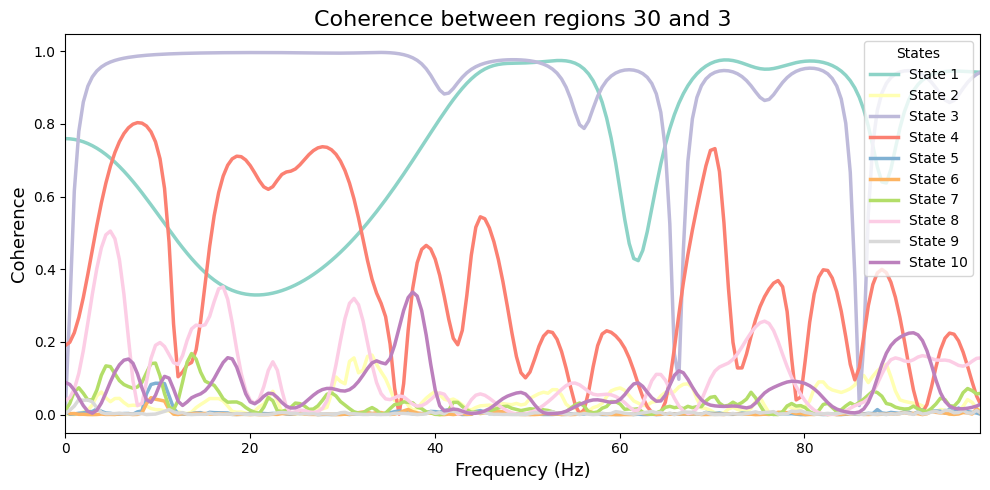

In [76]:
# for a specific session, plot the state coherence between two channels
coh = spectral_measures['coh']
chann_1 = 30
chann_2 = 3
graphics.plot_state_coherence(coh[selected_session,:,chann_1,chann_2],
                              f,
                              title='Coherence between regions %d and %d'%(chann_1,chann_2),
                              #highlight_freq=True,
                              )